In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
from pathlib import Path
root_path = Path.cwd().parent.absolute()
import sys
sys.path.append(str(root_path))
import os

In [2]:
from architectures.architectures import MLP

from flax import nnx
import jax
from jax._src.tree_util import tree_structure
import jax.numpy as jnp
from jaxtyping import Array

In [3]:
index = 3
device = jax.devices()[index] if jax.devices() else jax.devices('cpu')[0] # If only one gpu change index to 0
print(f"Selected device: {device}")

Selected device: cuda:3


# NODE setup

In [4]:
from architectures.node import NeuralODE

In [5]:
key = jax.random.PRNGKey(0)
rngs = nnx.Rngs(key)
model = MLP(din=2, num_layers=3, width_layers=128, dout=2, activation_fn="tanh", rngs=nnx.Rngs(0))
node = NeuralODE(
    dynamics_model=model,
    time_dependent=False,
    dt0=0.1,
    rtol=1e-4,
    atol=1e-6
)

# Initial condition
y0 = jnp.array([1.0, 0.5])

# Solve from t=0 to t=1
y_final = node(y0, (0.0, 1.0))
print("Final state:", y_final)

Final state: [[0.95567995 0.4358569 ]]


# G Mat

In [6]:
from geometry.G_matrix import G_matrix

In [7]:
# G_mat = G_matrix(node)

In [8]:
# # Test
# key = jax.random.PRNGKey(0)
# rngs = nnx.Rngs(key)

# n_samples = 100_000
# d = 2
# z_samples = jax.random.normal(key,(n_samples,d))

# z_samples = jax.device_put(z_samples,device)


In [9]:
# _,params = nnx.split(node)
# key,subkey = jax.random.split(key)
# eta = jax.tree.map(lambda p:jax.random.normal(subkey, p.shape)*10, params) #   jax.numpy.ones(p.shape)
# eta = jax.tree.map(lambda p: jax.device_put(p,device), eta)
# key,subkey = jax.random.split(key)
# epsilon = jax.tree.map(lambda p: jax.random.normal(subkey, p.shape)*0.1, params)
# eta_pert = jax.tree.map(lambda e,ep: e+ep, eta, epsilon)

In [10]:
# # Compute G_hat@eta
# result = G_mat.mvp(z_samples, eta)

In [11]:
# key,subkey = jax.random.split(key)
# z_samples = jax.random.normal(subkey,(n_samples,d))
# z_samples = jax.device_put(z_samples,device)

# # Test solver 
# result_solver, _ = G_mat.solve_system(z_samples, result, tol=1e-6, maxiter=20,x0 = eta_pert, method="minres")

In [12]:
# jax.tree.map(lambda x,y: jnp.linalg.norm(x-y)/jnp.linalg.norm(y), result_solver, eta)

In [13]:
# verify_result = G_mat.mvp(z_samples, result_solver)
# jax.tree.leaves(jax.tree.map(lambda x,y: jnp.linalg.norm(x-y)/jnp.linalg.norm(y), result, verify_result))

# Gradient flow test

In [36]:
@jax.jit
def quadratic_potential(x: Array) -> Array:
    """
    Evaluate quadratic potential U(x) = x^2 (sum over dimensions)
    Args:
        x: Array of shape (batch_size, d) - particle positions
    Returns:
        Array of shape (batch_size,) - potential values
    """
    return jnp.sum(x**2, axis=-1)


In [37]:
from typing import Optional
from jaxtyping import PyTree,Array
from flax import nnx
import jax

In [38]:
def compute_energy_gradient(node: nnx.Module, z_samples: Array, params: Optional[PyTree] = None) -> PyTree:
    """
    Compute gradient of energy functional F(ρ) = ∫ U(x)ρ(x)dx
    Args:
        node: Neural ODE model
        z_samples: Reference samples (batch_size, d)
        params: Parameters to evaluate gradient at (if None, uses current node params)
    Returns:
        Gradient ∇_θ F(θ)
    """
    if params is None:
        _, params = nnx.split(node)
    
    def energy_functional(p: PyTree) -> Array:
        # Transform reference samples through flow
        x_samples = node(z_samples, (0.0, 1.0), params=p)
        # Evaluate potential and average (Monte Carlo estimate)
        potential_values = quadratic_potential(x_samples)
        return jnp.mean(potential_values)
    
    return jax.grad(energy_functional)(params)

In [39]:
def evaluate_energy(node: nnx.Module, z_samples: Array, params: Optional[PyTree] = None) -> Array:
    """
    Evaluate current energy F(ρ_θ)
    Args:
        node: Neural ODE model
        z_samples: Reference samples
        params: Parameters (if None, uses current node params)
    Returns:
        Energy value
    """
    if params is None:
        _, params = nnx.split(node)

    x_samples = node(z_samples, (0.0, 1.0), params=params)
    potential_values = quadratic_potential(x_samples)
    return jnp.mean(potential_values),x_samples

In [40]:
# Cell 2: Initial Setup and Configuration

# Gradient flow parameters
h = 1e-1  # Time step size
max_iterations = 100
tolerance = 1e-6
n_samples = 20_000  # Monte Carlo sample size

# Initialize NODE with small parameters (near-identity pushforward)
key = jax.random.PRNGKey(42)
rngs = nnx.Rngs(key)

# Create NODE model
gradient_flow_model = MLP(din=2, num_layers=1, width_layers=32, dout=2, 
                         activation_fn="tanh", rngs=rngs)
gradient_flow_node = NeuralODE(
    dynamics_model=gradient_flow_model,
    time_dependent=False,
    dt0=0.1,
)

# Set parameters to be very small (near zero)
_, initial_params = nnx.split(gradient_flow_node)
scale_factor = 1e-2  # Small scaling to keep near identity

# Scale all parameters to be small
small_params = jax.tree.map(lambda p: p * scale_factor, initial_params)

# Merge back into the node
graphdef, _ = nnx.split(gradient_flow_node)
gradient_flow_node = nnx.merge(graphdef, small_params)

# Generate reference samples from λ = N(0, I)
key, subkey = jax.random.split(key)
z_samples = jax.random.normal(subkey, (n_samples, 2))

# Initialize tracking arrays
energy_history = []
solver_stats = []
param_norms = []

print(f"Initial setup complete:")
print(f"- Time step: {h}")
print(f"- Max iterations: {max_iterations}")
print(f"- Sample size: {n_samples}")
print(f"- Parameter scale factor: {scale_factor}")

# Verify initial energy (should be ~1.0 since E[x^2] for N(0,I) in 2D is 2.0)
_, current_params = nnx.split(gradient_flow_node)
initial_energy,push_samples = evaluate_energy(gradient_flow_node, z_samples, current_params)
print(f"- Initial energy: {initial_energy:.6f}")

energy_history.append(initial_energy)

Initial setup complete:
- Time step: 0.1
- Max iterations: 100
- Sample size: 20000
- Parameter scale factor: 0.01
- Initial energy: 2.023732


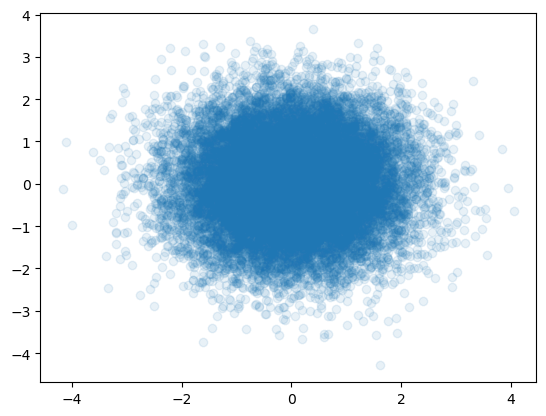

In [41]:
import matplotlib.pyplot as plt

plt.scatter(push_samples[:,0], push_samples[:,1], alpha=0.1)

In [42]:
# Quick alternative: try JAX's built-in CG with regularization
def solve_with_regularization(G_mat, z_samples, b, params, reg_param=1e-6):
    """
    Alternative solver using regularized CG
    """
    def regularized_matvec(eta):
        return jax.tree.map(lambda x, y: x + reg_param * y, 
                           G_mat.mvp(z_samples, eta, params), eta)
    
    from jax.scipy.sparse.linalg import cg
    return cg(regularized_matvec, b, tol=1e-6, maxiter=100)

In [43]:

def gradient_flow_step(node: nnx.Module, z_samples: Array, G_mat: G_matrix, 
                      step_size: float = 0.01, solver_tol: float = 1e-6, 
                      solver_maxiter: int = 10) -> tuple[nnx.Module, dict]:
    """
    Perform one gradient flow step: θ^{k+1} = θ^k + h * η
    where G(θ^k) η = -∇_θ F(θ^k)
    
    Args:
        node: Current Neural ODE model
        z_samples: Reference samples for Monte Carlo estimation
        G_mat: G-matrix object for linear system solving
        step_size: Gradient flow step size h
        solver_tol: Tolerance for G-matrix linear solver
        solver_maxiter: Maximum iterations for linear solver
        
    Returns:
        updated_node: Node with updated parameters
        step_info: Dictionary with step diagnostics
    """
    
    # Get current parameters
    _, current_params = nnx.split(node)
    
    # Compute energy gradient ∇_θ F(θ)
    energy_grad = compute_energy_gradient(node, z_samples, current_params)
    # print(energy_grad)
    # Solve linear system: G(θ) η = -∇_θ F(θ)
    neg_energy_grad = jax.tree.map(lambda x: -x, energy_grad)
    eta, solver_info = G_mat.solve_system(z_samples, neg_energy_grad, 
                                         params=current_params,
                                         tol=solver_tol, 
                                         maxiter=solver_maxiter,
                                         method="minres")
    # def regularized_matvec(eta):
    #     return jax.tree.map(lambda x, y: x + 1e-6 * y, 
    #                    G_mat.mvp(z_samples, eta, current_params), eta)

    # eta, solver_info = jax.scipy.sparse.linalg.cg(regularized_matvec, neg_energy_grad, tol=1e-6, maxiter=100)
    # print(solver_info)
    # print(eta)
    # Update parameters: θ^{k+1} = θ^k + h * η
    updated_params = jax.tree.map(lambda p, e: p + step_size * e, current_params, eta)
    
    # Create updated node
    graphdef, _ = nnx.split(node)
    updated_node = nnx.merge(graphdef, updated_params)
    
    # Compute diagnostics
    grad_norm = jnp.sqrt(sum(jax.tree.leaves(jax.tree.map(lambda x: jnp.sum(x**2), energy_grad))))
    eta_norm = jnp.sqrt(sum(jax.tree.leaves(jax.tree.map(lambda x: jnp.sum(x**2), eta))))
    param_norm = jnp.sqrt(sum(jax.tree.leaves(jax.tree.map(lambda x: jnp.sum(x**2), updated_params))))
    
    step_info = {
        # 'solver_success': solver_info['success'],
        # 'solver_iterations': solver_info['iterations'],
        # 'solver_residual': solver_info['norm_res'],
        'gradient_norm': grad_norm,
        'eta_norm': eta_norm,
        'param_norm': param_norm,
        'step_size': step_size
    }
    
    return updated_node, step_info




In [44]:

print("Testing single gradient flow step...")

# Initialize G-matrix for gradient flow
G_mat_flow = G_matrix(gradient_flow_node)

# Store initial state
_, initial_params = nnx.split(gradient_flow_node)
initial_energy,initial_samples = evaluate_energy(gradient_flow_node, z_samples, initial_params)

# Perform one gradient flow step
updated_node, step_info = gradient_flow_step(gradient_flow_node, z_samples, G_mat_flow, 
                                           step_size=h, solver_tol=tolerance)

# Compute energy after step
_, updated_params = nnx.split(updated_node)
final_energy,final_samples = evaluate_energy(updated_node, z_samples, updated_params)

# Verification checks
energy_decrease = initial_energy - final_energy
relative_decrease = energy_decrease / initial_energy

print(f"\n=== Step Verification Results ===")
print(f"Initial energy:     {initial_energy:.6f}")
print(f"Final energy:       {final_energy:.6f}")
print(f"Energy decrease:    {energy_decrease:.6f}")
print(f"Relative decrease:  {relative_decrease:.4%}")
# print(f"Solver success:     {step_info['solver_success']}")
# print(f"Solver iterations:  {step_info['solver_iterations']}")
# print(f"Solver residual:    {step_info['solver_residual']:.2e}")
print(f"Gradient norm:      {step_info['gradient_norm']:.6f}")
print(f"Update norm:        {step_info['eta_norm']:.6f}")

# Validation
assert energy_decrease > 0, f"Energy should decrease! Got decrease: {energy_decrease}"
# assert step_info['solver_success'], "Linear solver should converge!"
# assert step_info['solver_residual'] < tolerance * 10, "Solver residual too large!"

print(f"\n✓ All checks passed! Gradient flow step working correctly.")

Testing single gradient flow step...

=== Step Verification Results ===
Initial energy:     2.023732
Final energy:       2.073475
Energy decrease:    -0.049743
Relative decrease:  -2.4580%
Gradient norm:      0.044942
Update norm:        5.999299


AssertionError: Energy should decrease! Got decrease: -0.049742937088012695

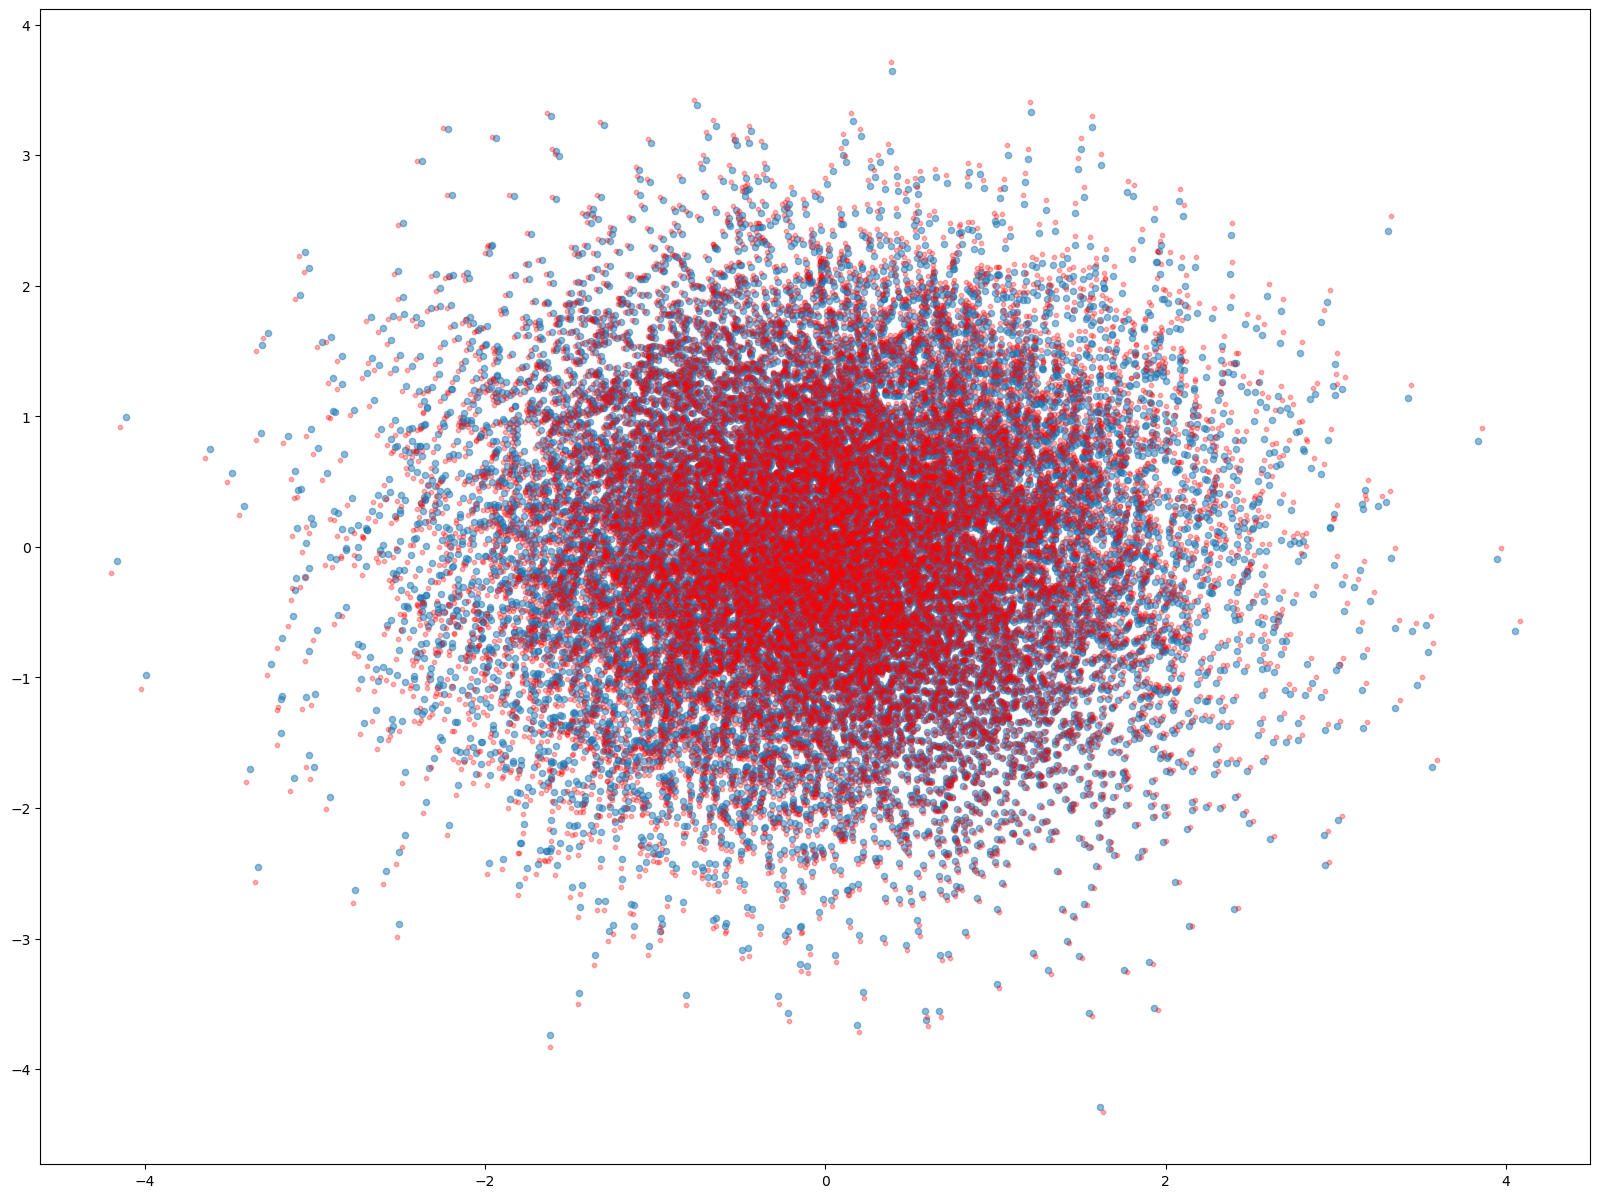

In [45]:
fig = plt.figure(figsize=(20,15))
plt.scatter(initial_samples[:,0],initial_samples[:,1], alpha=0.5,s = 20)
plt.scatter(final_samples[:,0],final_samples[:,1], alpha=0.3,s = 10, c = 'r')

Starting gradient flow integration...
Initial energy: 2.023732
Target: converge to origin (energy → 0)
Iter   0: Energy = 2.006110, Decrease = 0.017622
Mean samples: [ 0.00243023 -0.00151399]
Covariance matrix:
[[1.0060031  0.01546381]
 [0.01546381 1.0001781 ]]


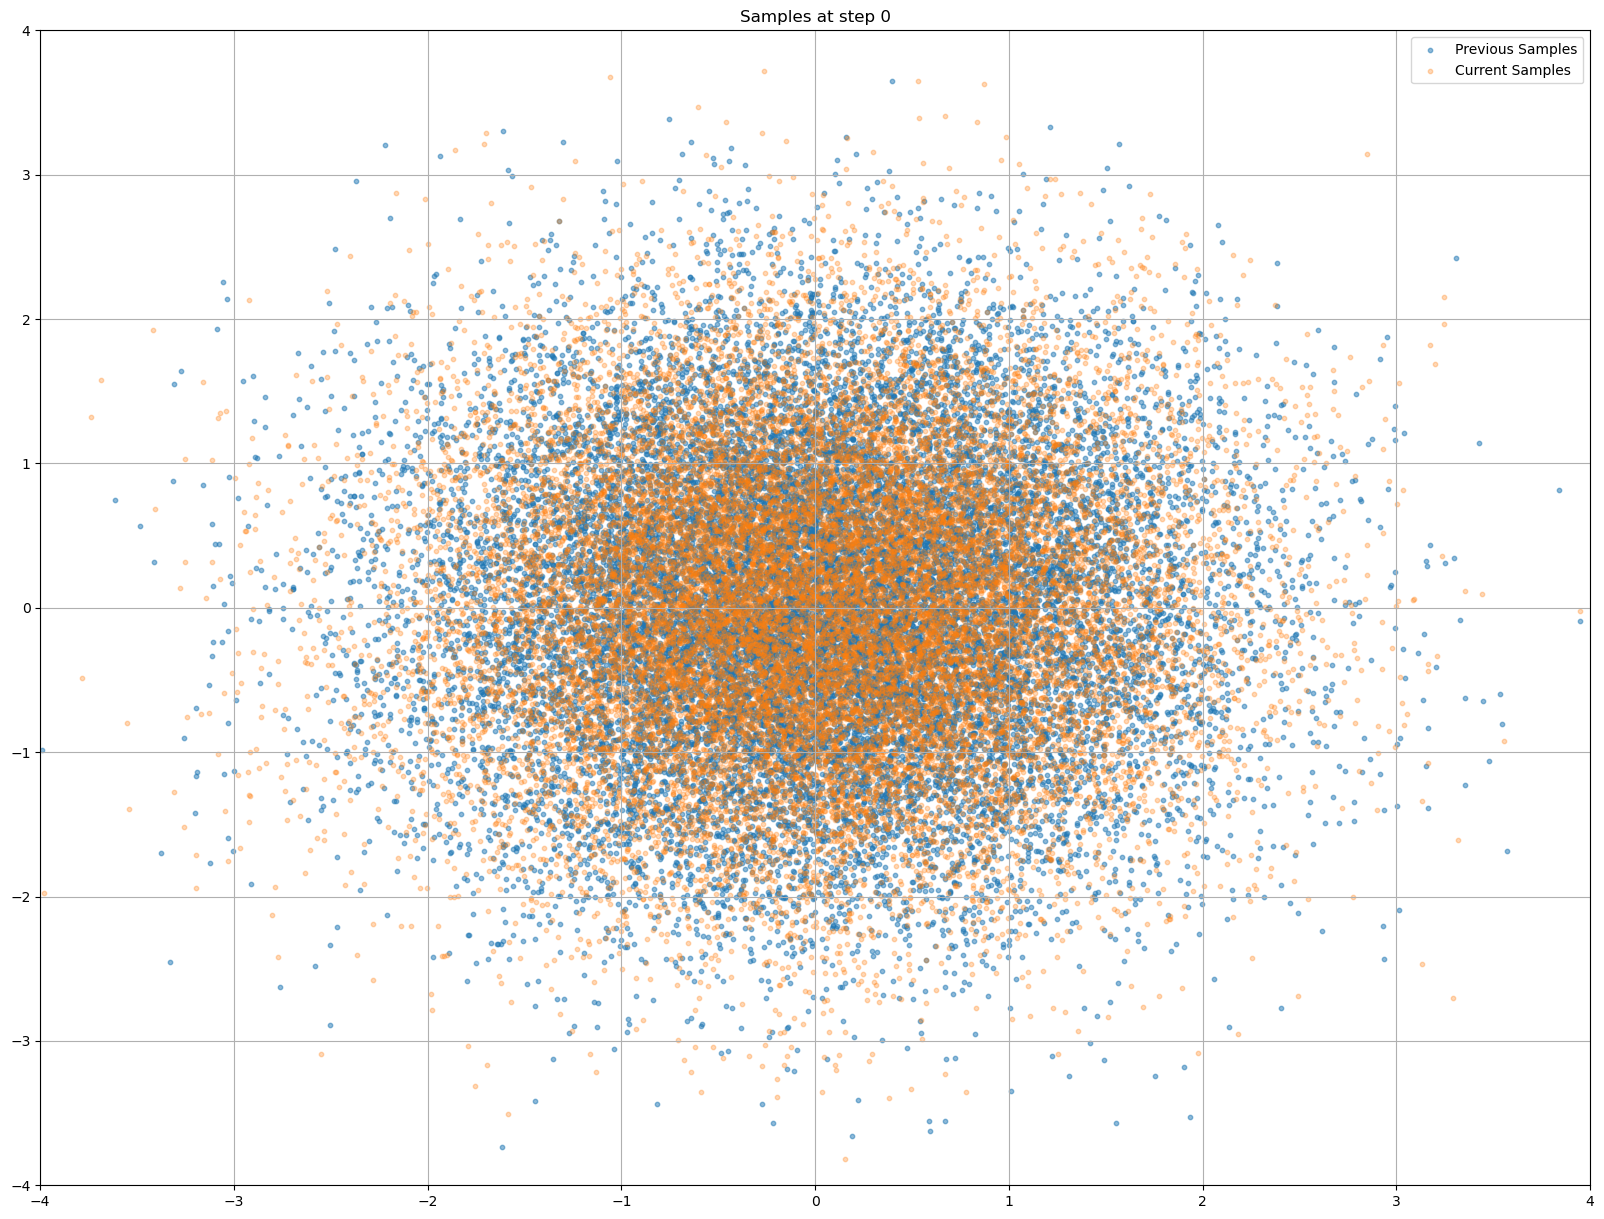

Iter  10: Energy = 0.023450, Decrease = 2.000282
Mean samples: [ 0.00185573 -0.00118737]
Covariance matrix:
[[0.01242866 0.00061888]
 [0.00061888 0.01101725]]


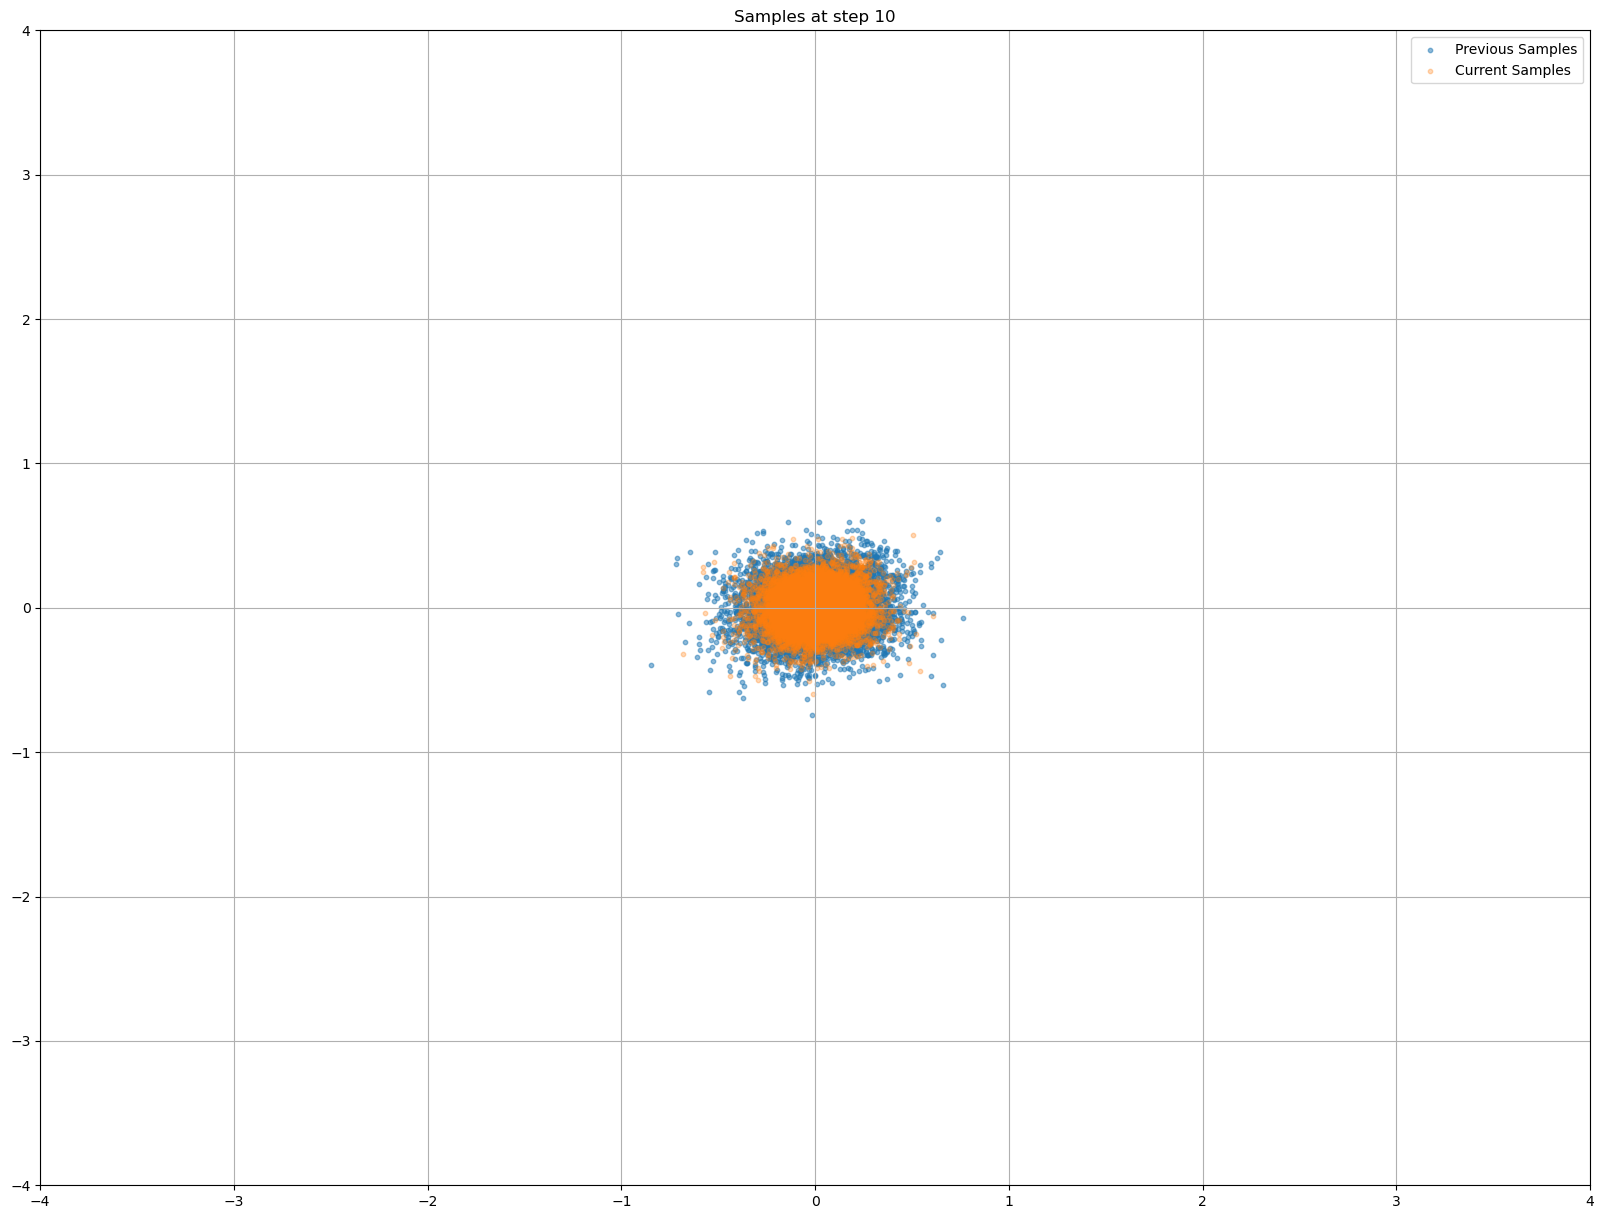

Iter  20: Energy = 0.002150, Decrease = 2.021582
Mean samples: [0.00641145 0.00229115]
Covariance matrix:
[[0.00109467 0.00050618]
 [0.00050618 0.00100865]]


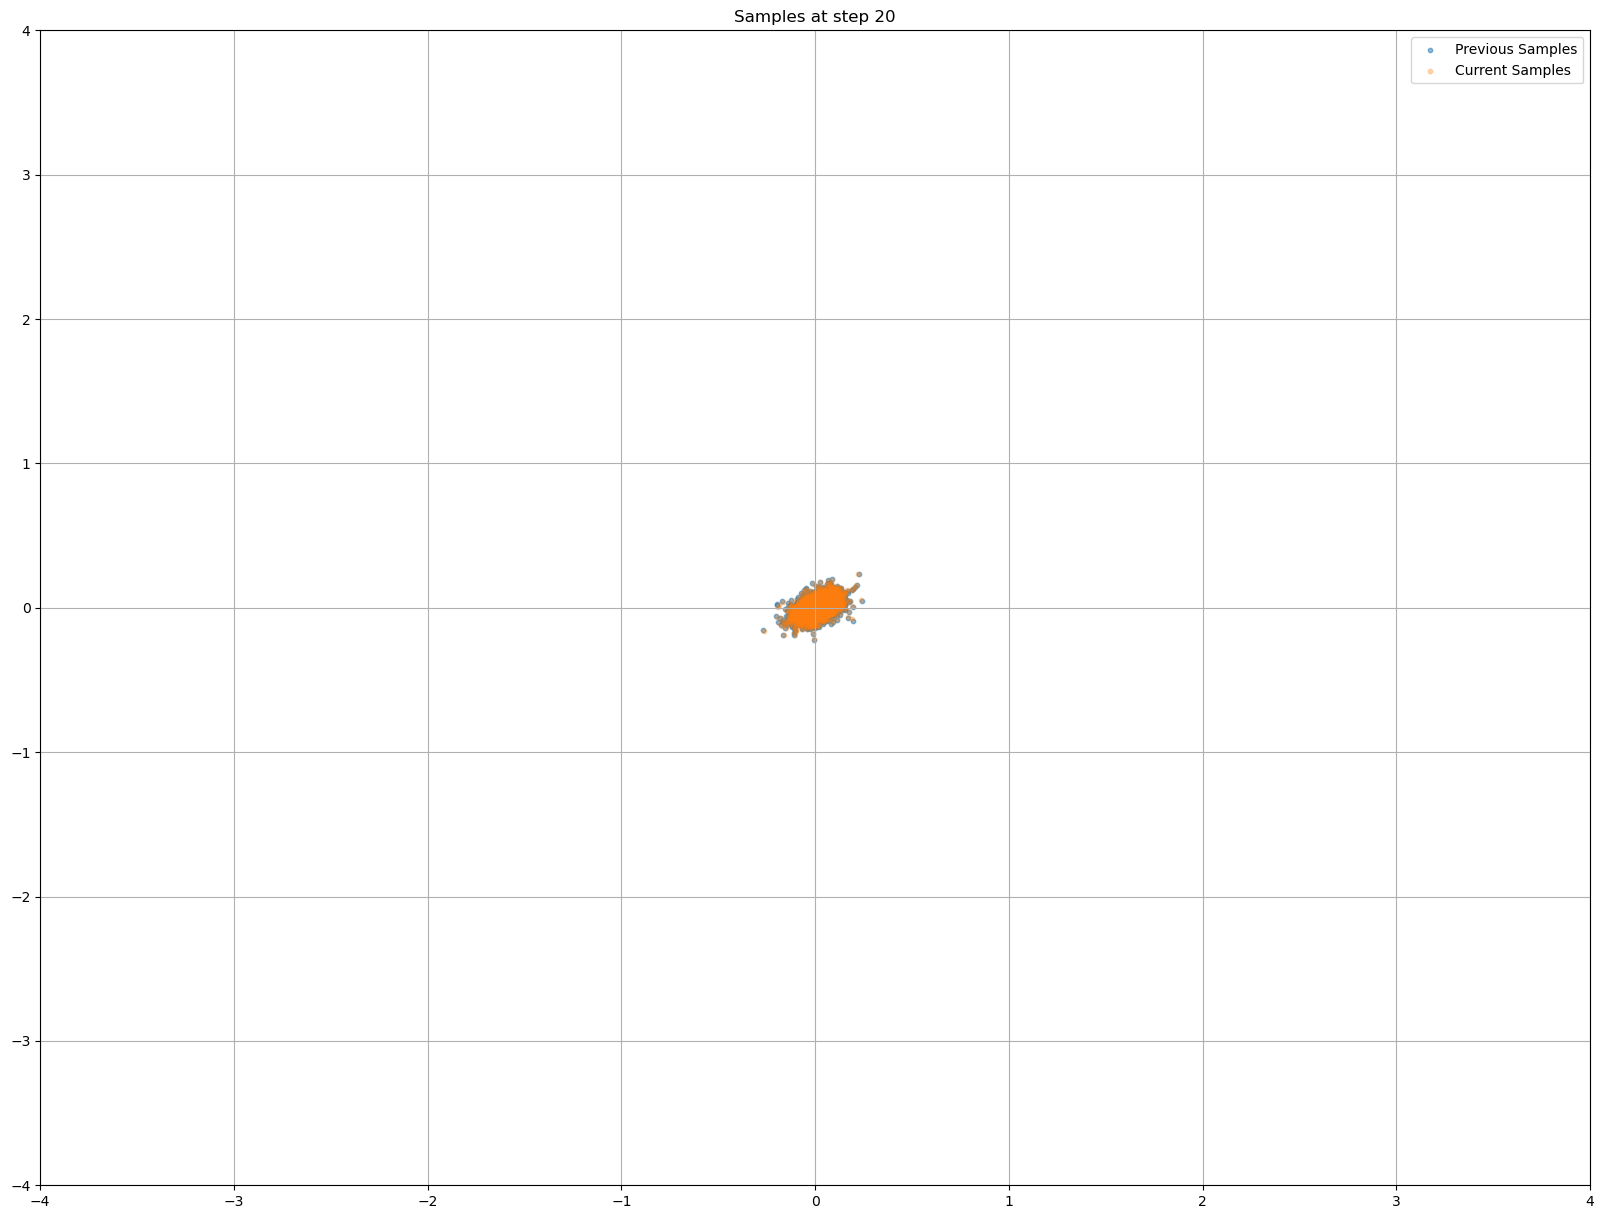

Iter  30: Energy = 0.001344, Decrease = 2.022388
Mean samples: [0.00682281 0.00321496]
Covariance matrix:
[[0.00060069 0.00037417]
 [0.00037417 0.00068666]]


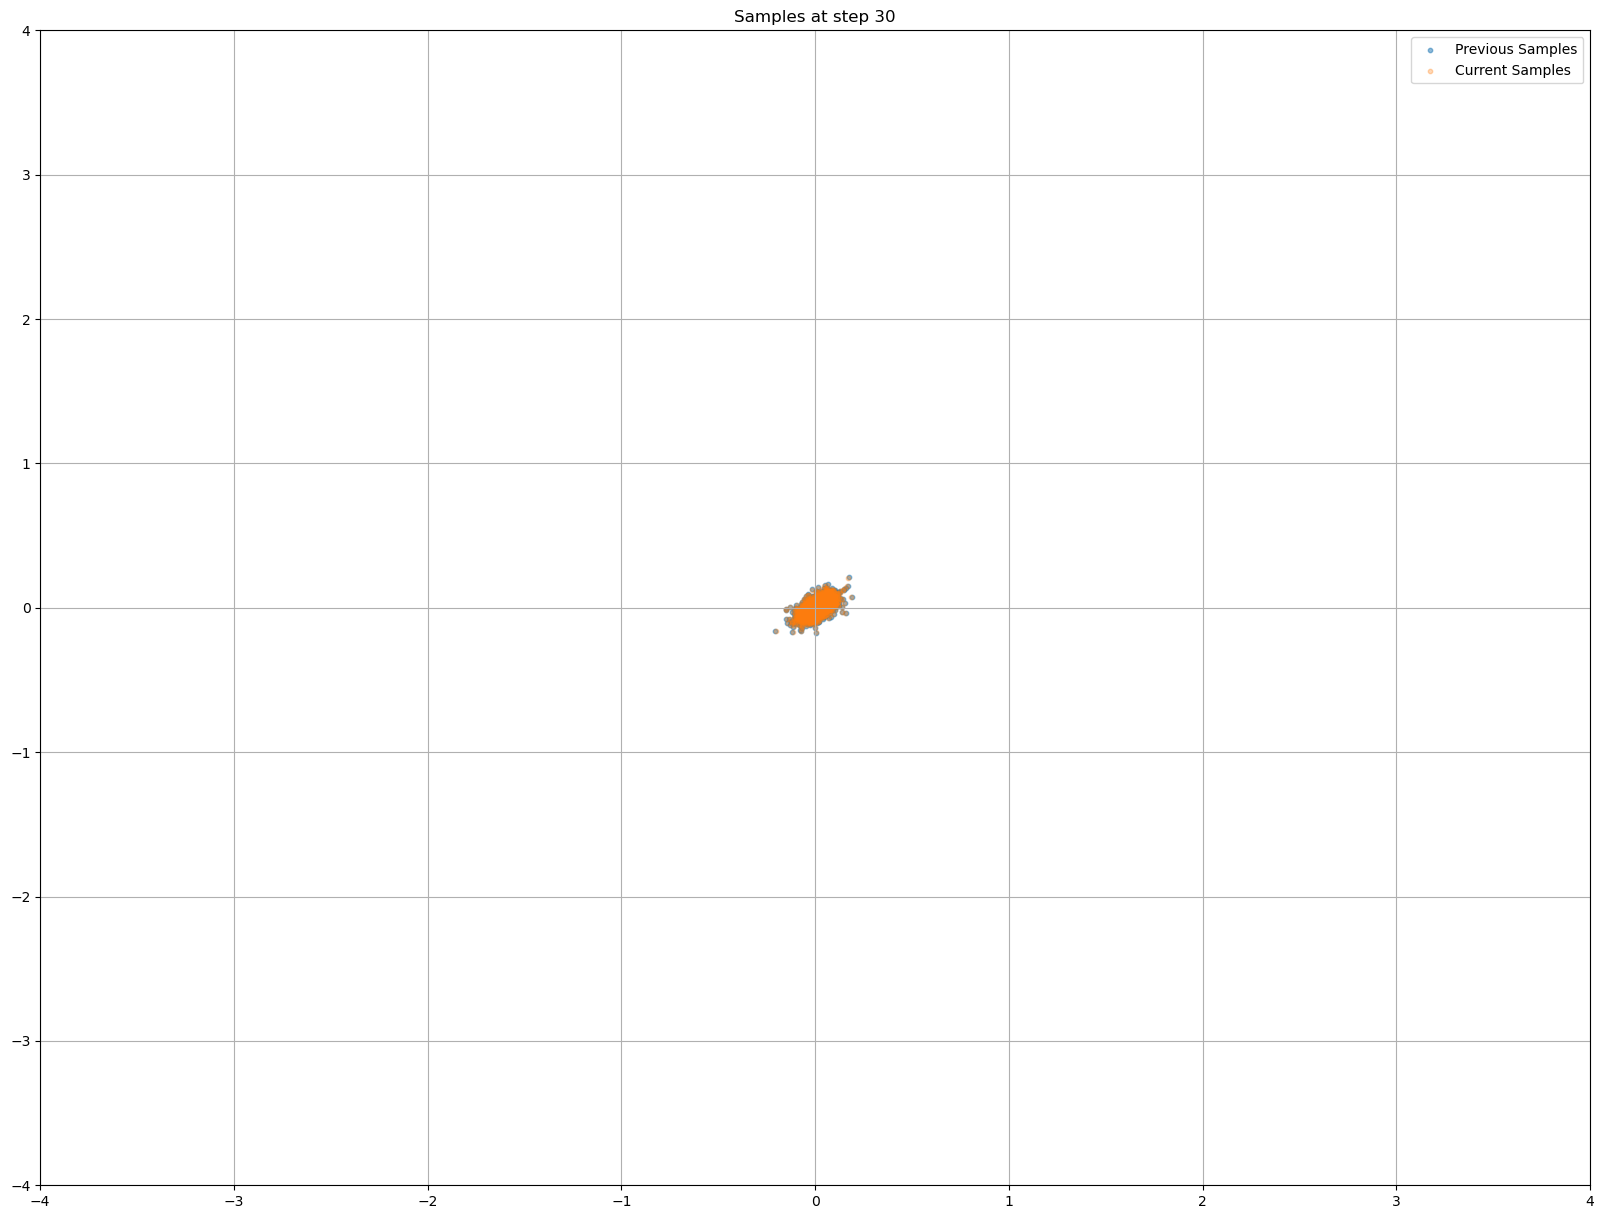

Iter  40: Energy = 0.000841, Decrease = 2.022891
Mean samples: [0.00515194 0.00247563]
Covariance matrix:
[[0.00035933 0.00024586]
 [0.00024586 0.00044858]]


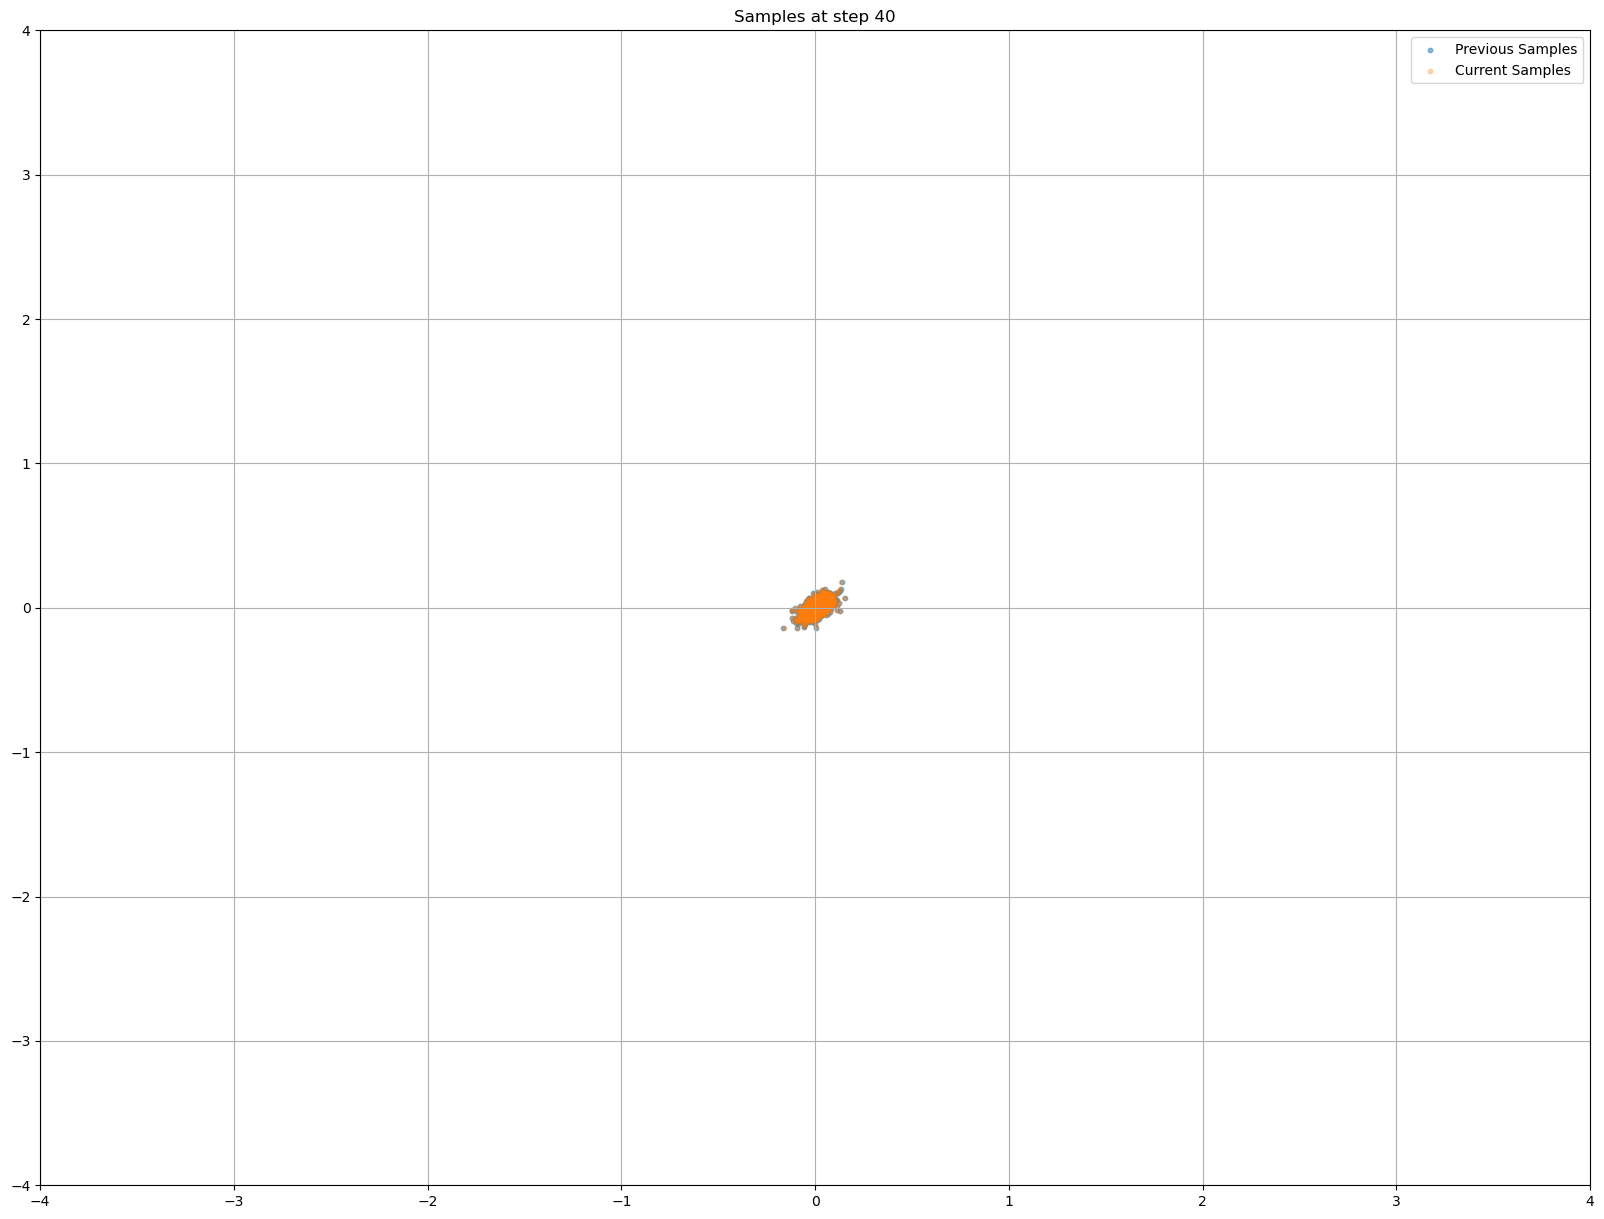

Iter  50: Energy = 0.000576, Decrease = 2.023156
Mean samples: [0.00418615 0.00183557]
Covariance matrix:
[[0.00023803 0.00017446]
 [0.00017446 0.00031687]]


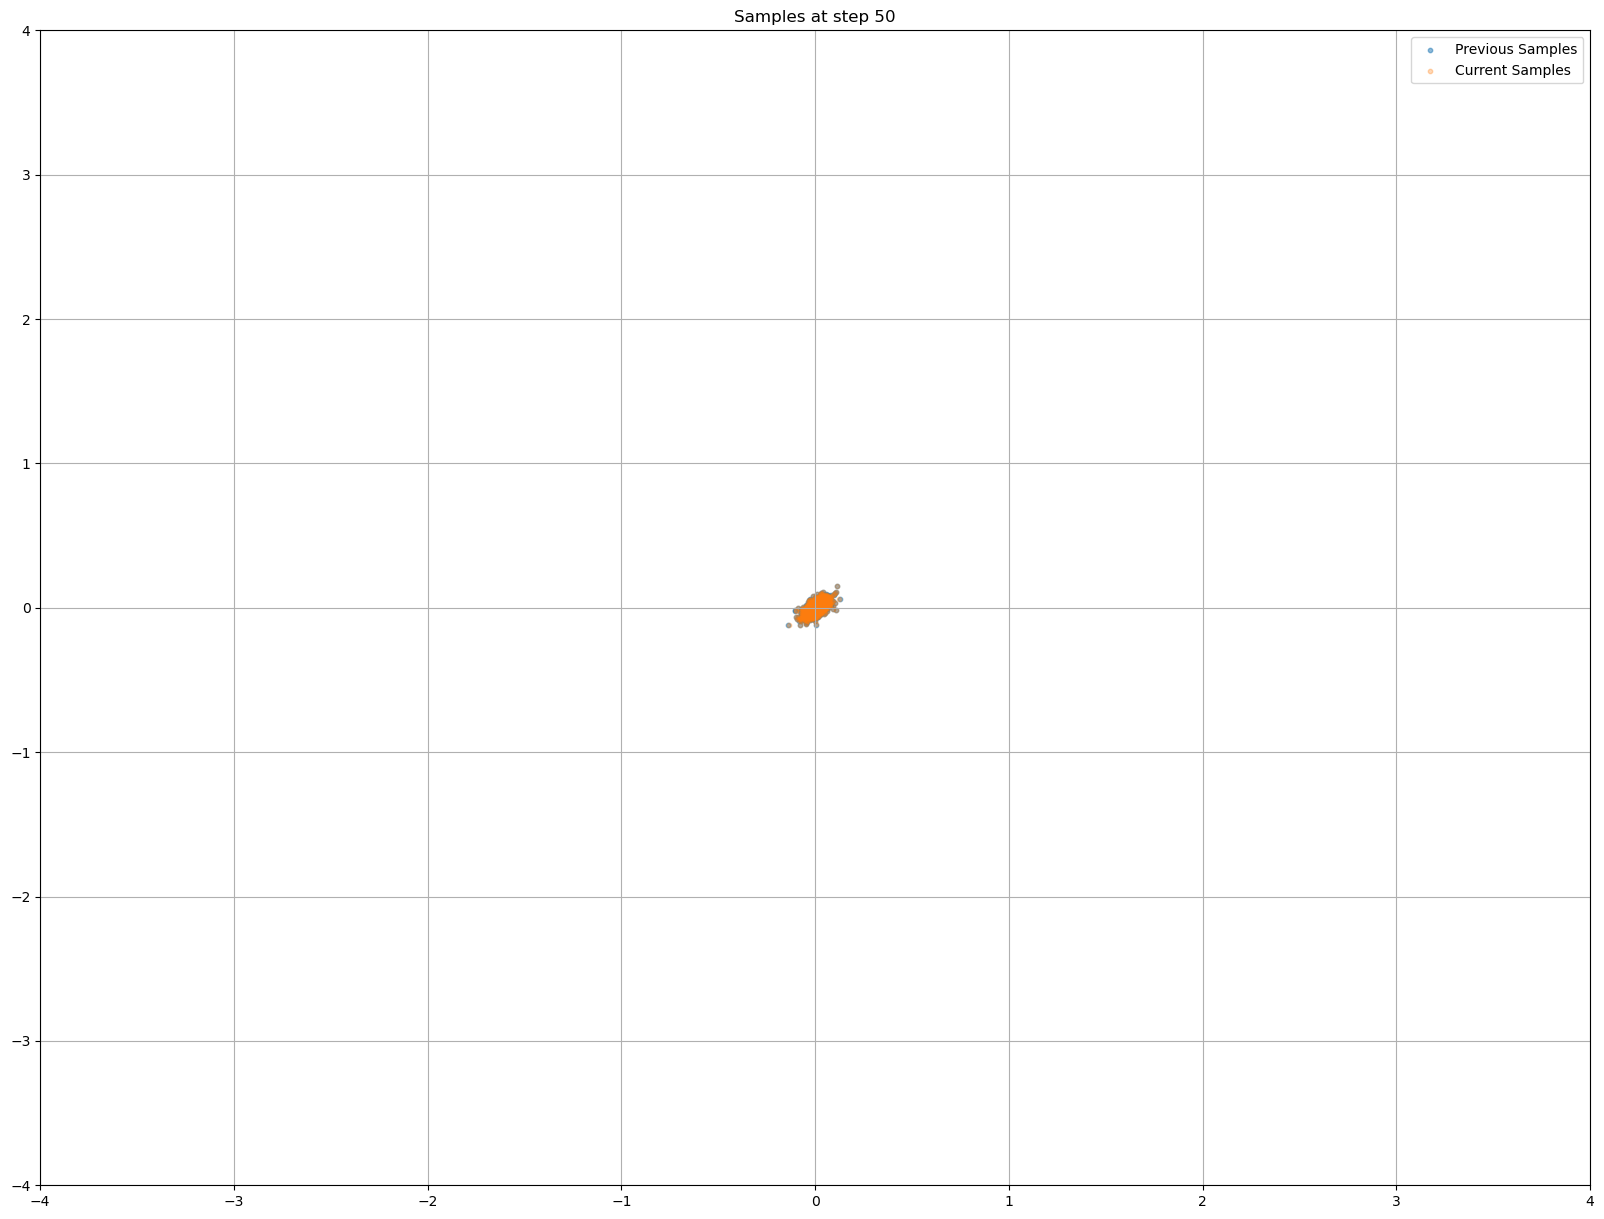

Iter  60: Energy = 0.000411, Decrease = 2.023321
Mean samples: [0.00342739 0.00157493]
Covariance matrix:
[[0.00016785 0.00012597]
 [0.00012597 0.00022859]]


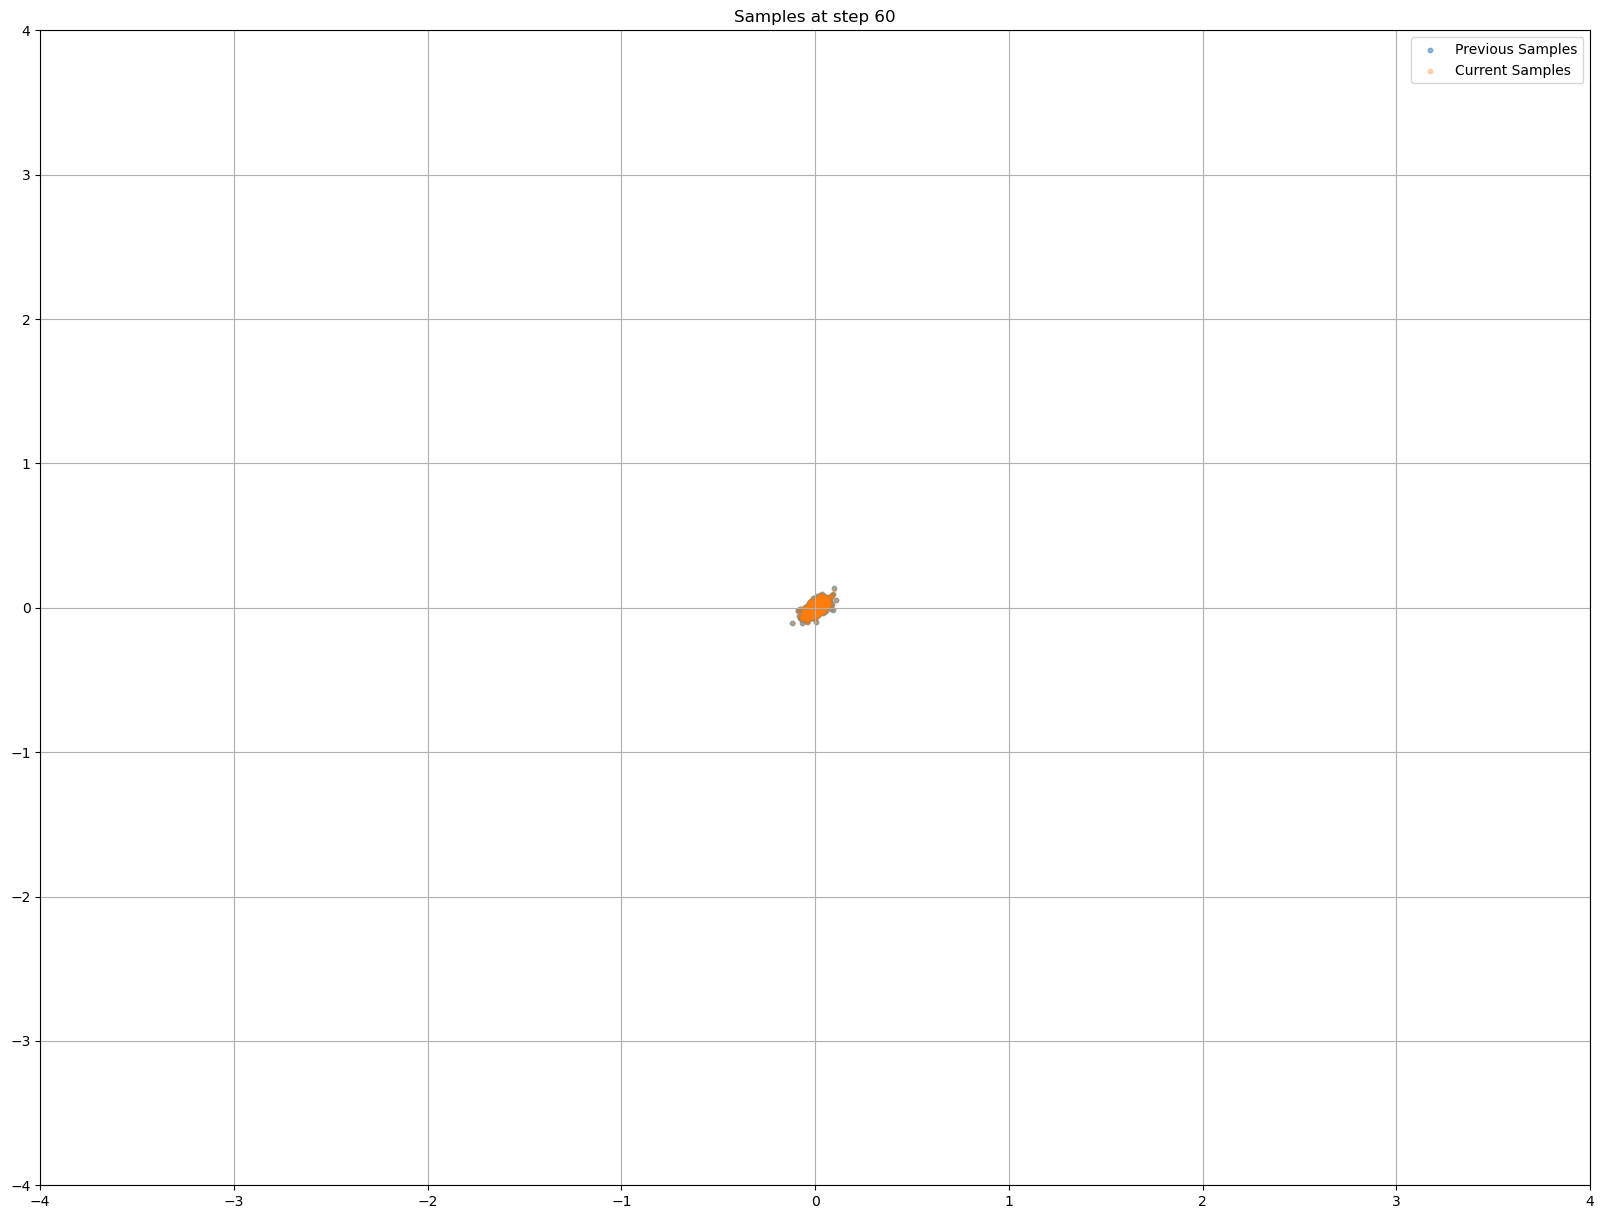

Iter  70: Energy = 0.000305, Decrease = 2.023427
Mean samples: [0.00284892 0.00119298]
Covariance matrix:
[[1.2278426e-04 9.3766052e-05]
 [9.3766052e-05 1.7249458e-04]]


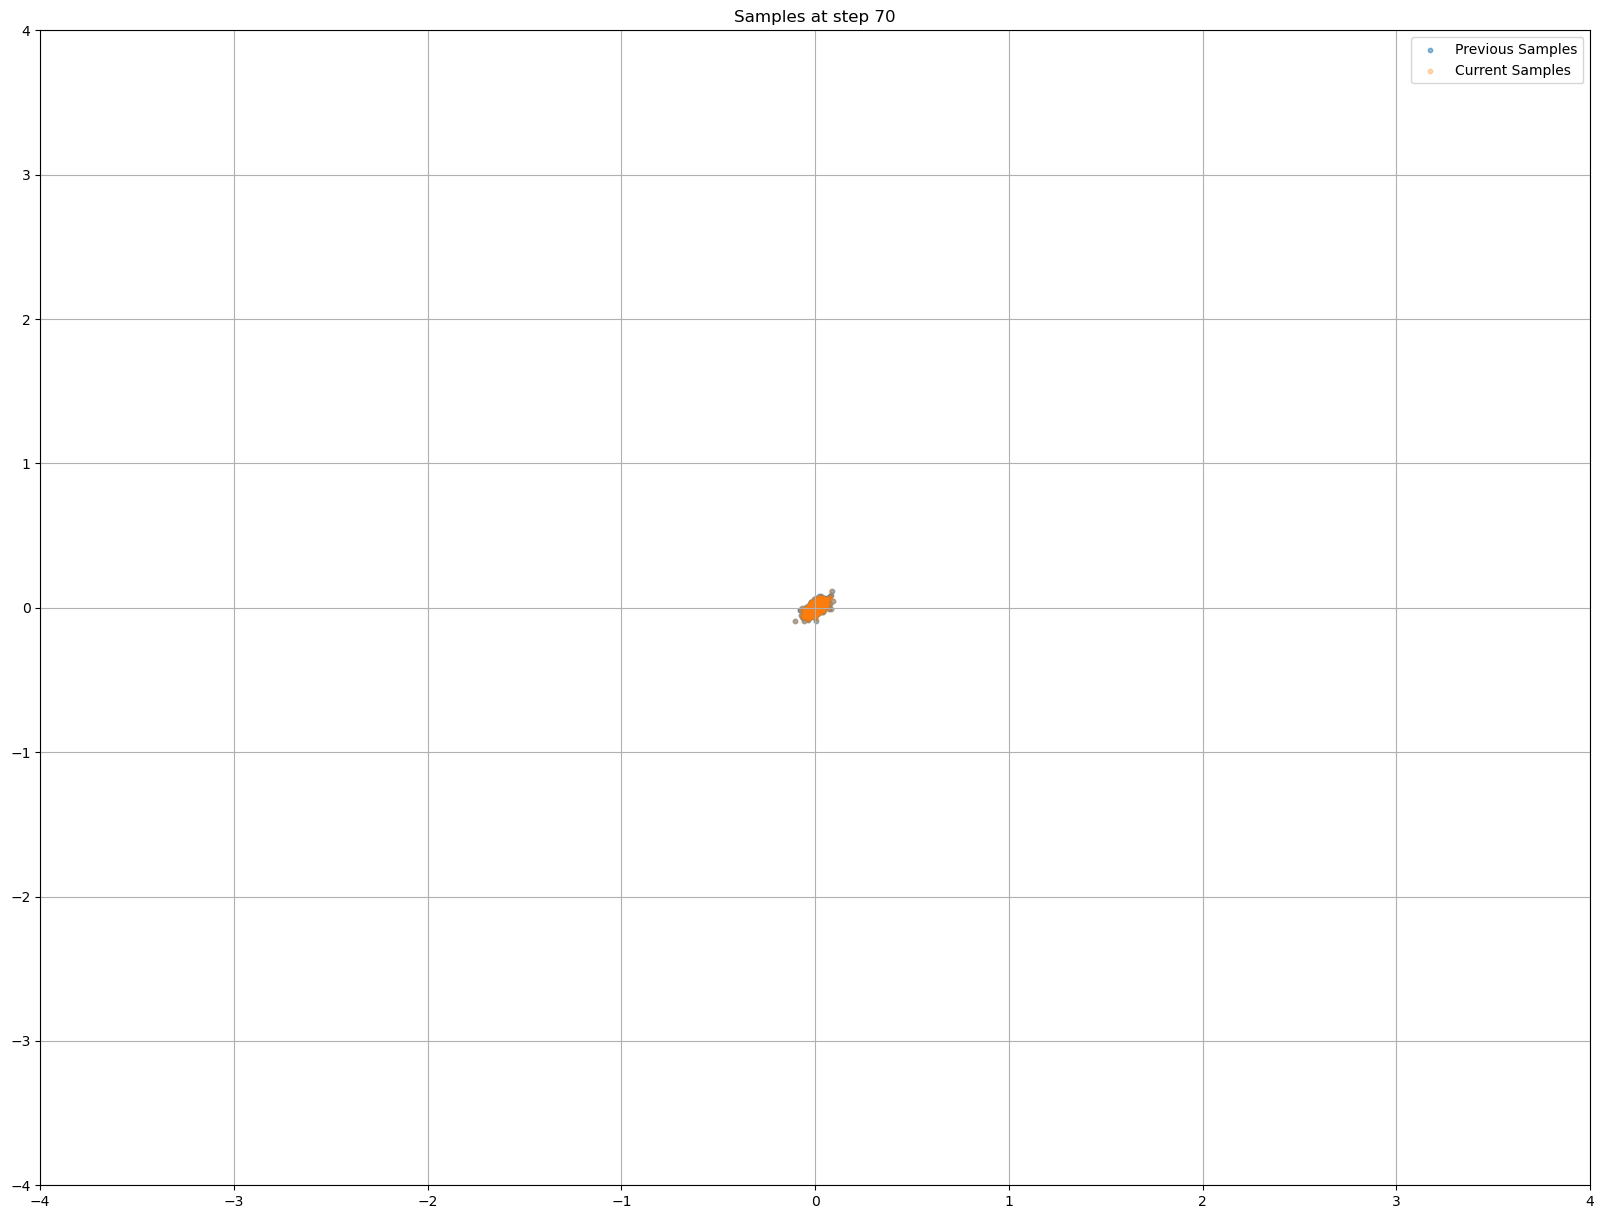

Iter  80: Energy = 0.000241, Decrease = 2.023491
Mean samples: [0.00222886 0.00104705]
Covariance matrix:
[[9.7169235e-05 7.9745354e-05]
 [7.9745354e-05 1.3781202e-04]]


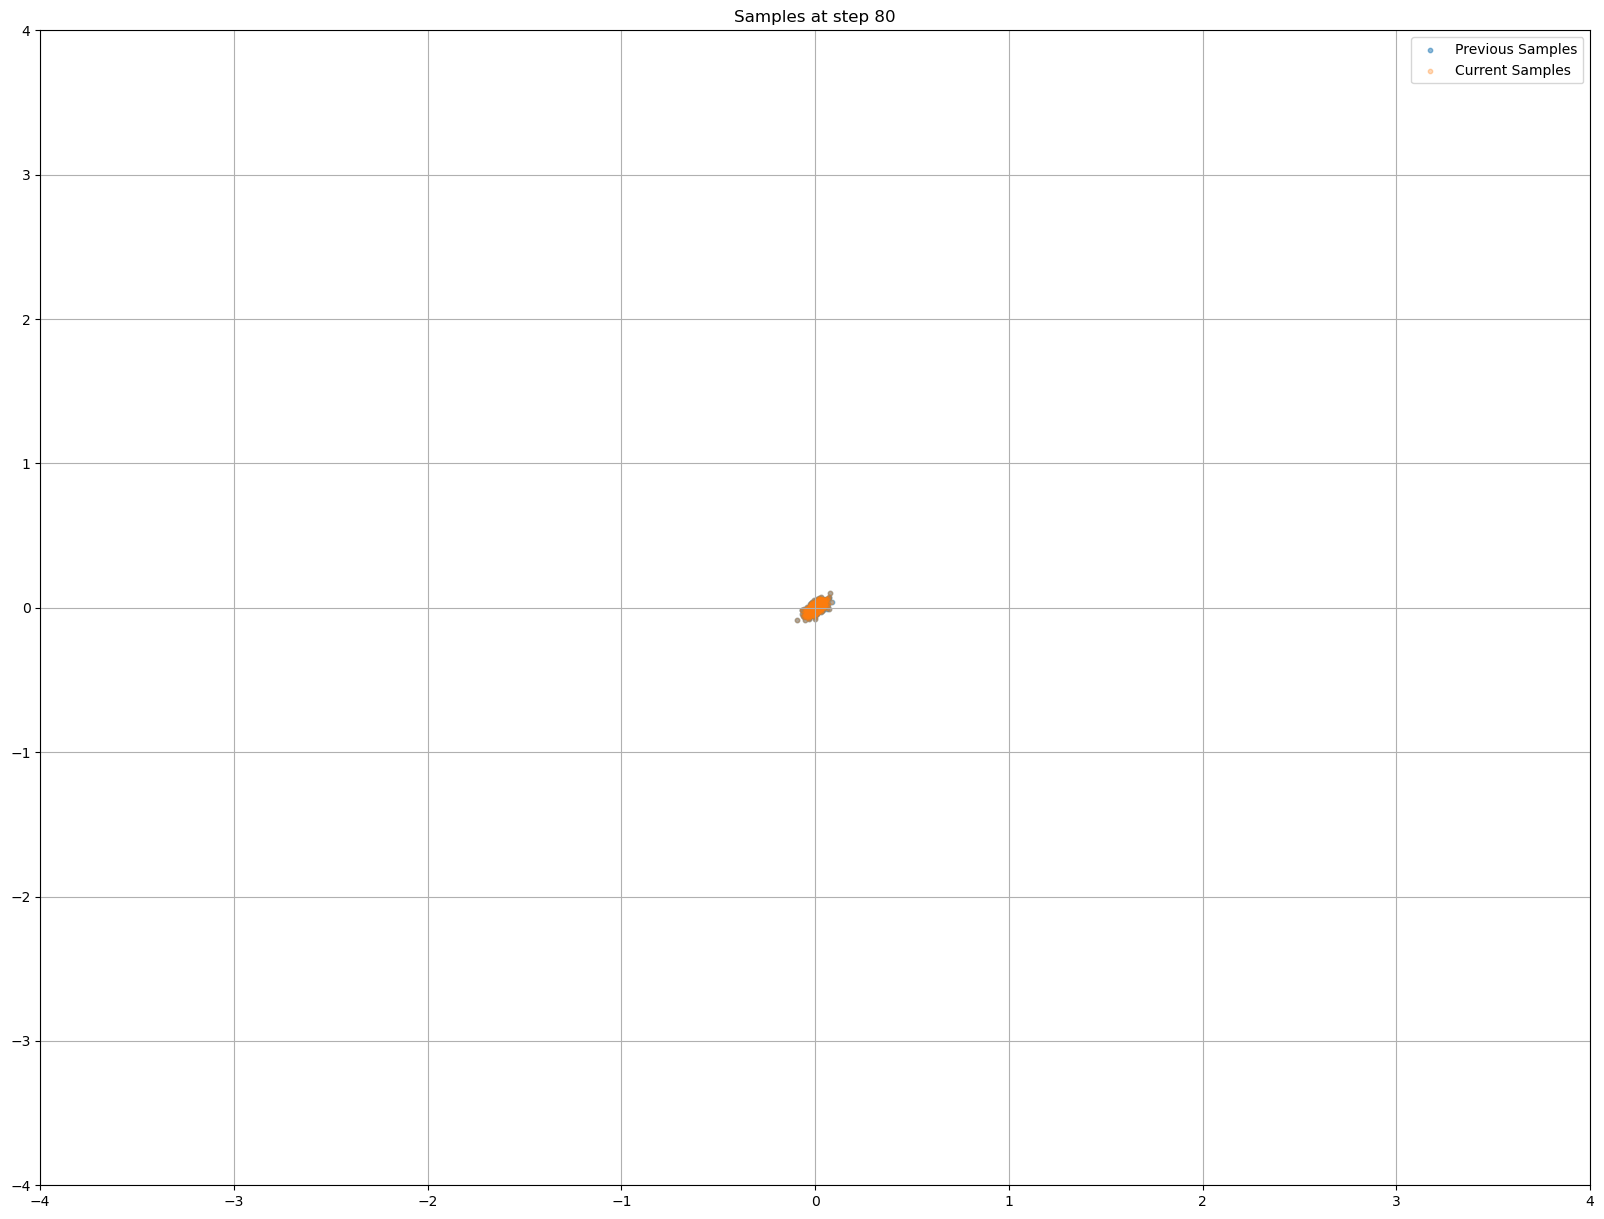

Iter  90: Energy = 0.000195, Decrease = 2.023537
Mean samples: [0.00196113 0.00074297]
Covariance matrix:
[[7.88153120e-05 6.60814403e-05]
 [6.60814403e-05 1.11447385e-04]]


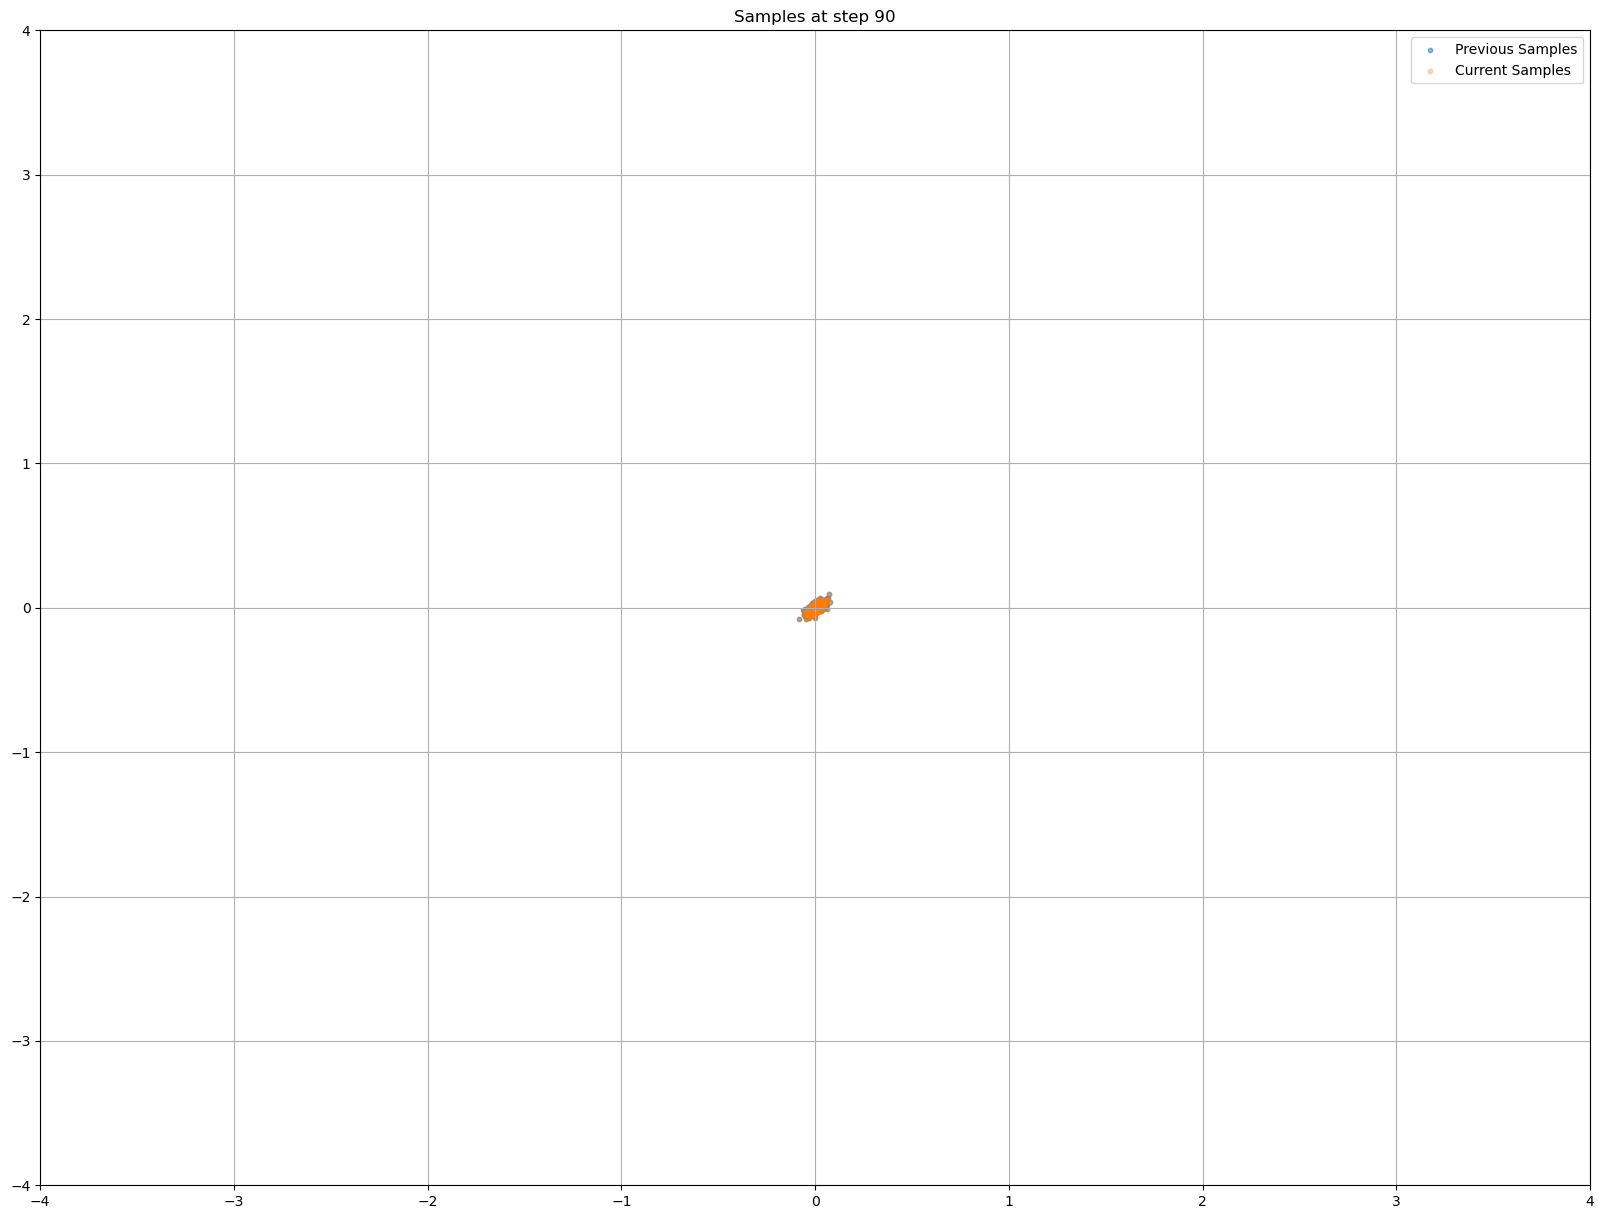


=== Integration Complete ===
Total iterations:    100
Initial energy:      2.023732
Final energy:        0.000167
Total decrease:      2.023564
Reduction ratio:     0.0001
Final param norm:    4.279130


In [46]:
print("Starting gradient flow integration...")

# Reset to initial state
graphdef, _ = nnx.split(gradient_flow_node)
gradient_flow_node = nnx.merge(graphdef, small_params)

# Clear tracking arrays
energy_history = []
solver_stats = []
param_norms = []

# Initial energy
_, current_params = nnx.split(gradient_flow_node)
current_energy,samples_prev = evaluate_energy(gradient_flow_node, z_samples, current_params)
energy_history.append(current_energy)

print(f"Initial energy: {current_energy:.6f}")
print(f"Target: converge to origin (energy → 0)")

key,subkey= jax.random.split(key)
z_samples_fixed = jax.random.normal(subkey, (n_samples, 2))
z_samples_fixed = jax.device_put(z_samples_fixed,device)
# Main integration loop
for iteration in range(max_iterations):

    key,subkey= jax.random.split(key)
    z_samples = jax.random.normal(subkey,(n_samples,2))
    
    # Perform gradient flow step
    gradient_flow_node, step_info = gradient_flow_step(gradient_flow_node, z_samples, G_mat_flow,
                                                      step_size=h, solver_tol=tolerance)
    # Evaluate new energy
    _, current_params = nnx.split(gradient_flow_node)
    current_energy,samples_next = evaluate_energy(gradient_flow_node, z_samples_fixed, current_params)
    
    # Store diagnostics
    energy_history.append(current_energy)
    solver_stats.append(step_info)
    param_norm = jnp.sqrt(sum(jax.tree.leaves(jax.tree.map(lambda x: jnp.sum(x**2), current_params))))
    param_norms.append(param_norm)
    
    # Progress reporting
    if iteration % 10 == 0 :
        energy_decrease = energy_history[0] - current_energy
        mean_samples = jnp.mean(samples_next,axis=0)
        cov_mat = jnp.cov(samples_next.T)
        print(f"Iter {iteration:3d}: Energy = {current_energy:.6f}, "
              f"Decrease = {energy_decrease:.6f}")
        print(f"Mean samples: {mean_samples}")
        print(f"Covariance matrix:\n{cov_mat}")
        fig = plt.figure(figsize=(20,15))
        plt.scatter(samples_prev[:,0], samples_prev[:,1], s = 10, alpha = 0.5,label = "Previous Samples")
        plt.scatter(samples_next[:,0], samples_next[:,1], s = 10, alpha = 0.3,label = "Current Samples")
        plt.title(f"Samples at step {iteration}")
        plt.grid(visible = True)
        plt.xlim(-4.0,4.0)
        plt.ylim(-4.0,4.0)
        plt.legend()
        plt.show()
    samples_prev = samples_next
    # Early stopping conditions
    if current_energy < tolerance:
        print(f"✓ Converged! Energy below tolerance at iteration {iteration}")
        break
        
    # if iteration > 5 and abs(energy_history[-1] - energy_history[-2]) < tolerance * 1e-2:
    #     print(f"✓ Energy converged at iteration {iteration}")
    #     break

# Final summary
final_energy = energy_history[-1]
total_decrease = energy_history[0] - final_energy

print(f"\n=== Integration Complete ===")
print(f"Total iterations:    {len(energy_history)-1}")
print(f"Initial energy:      {energy_history[0]:.6f}")
print(f"Final energy:        {final_energy:.6f}")
print(f"Total decrease:      {total_decrease:.6f}")
print(f"Reduction ratio:     {final_energy/energy_history[0]:.4f}")
print(f"Final param norm:    {param_norms[-1]:.6f}")